# This is the jupyter notebook regarding the calulcation for the lensing source Q0957+562

In [ ]:
# Let's load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.io.fits as pf


# pyCCF: https://ui.adsabs.harvard.edu/abs/2018ascl.soft05032S/abstract
# https://bitbucket.org/cgrier/python_ccf_code/src/master/ and http://ascl.net/1805.032
# taufit: https://github.com/burke86/taufit
# celerite: https://github.com/dfm/celerite

# package for pyCCF, Sun et al. 2020
import PYCCF
# pacakges for DRW, Burke et al. 2021
import celerite
from celerite import terms

from taufit.taufit import fit_drw
from astropy import units as u

In [ ]:
# Please note that the value can change slightly from the one that you can see within the article due to the
# randomization and steps of simulation you would use,  number of production samples,
# Additionally due to Monte Carlo simulations trials you likely will obtain slightly different results

In [ ]:
# This is a nice scientific library that produces plots used in the article
plt.style.reload_library()
plt.style.use(['science', 'ieee'])

In [6]:
# Loading fits file of the light curves
# Please change the name of a file if you would like to use other than provided within the notebook
lc_all = []
lc_file = pf.open('Q0957_lc_image2.fits')
lc_all.append(lc_file[1].data)
lc_file.close()

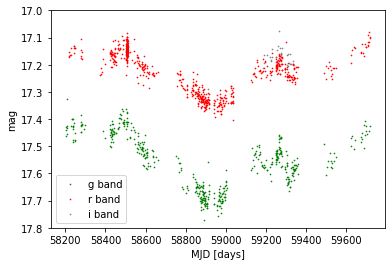

In [7]:
lc_seg = lc_all[0]
selg  = np.where((lc_seg ['filtercode']=='zg')&(lc_seg ['catflags']==0), True, False)
plt.scatter(lc_seg ['mjd'][selg ], lc_seg ['mag'][selg ], label = 'g band', color ='green', s=0.4)

selr  = np.where((lc_seg ['filtercode']=='zr')&(lc_seg ['catflags']==0), True, False)
plt.scatter(lc_seg ['mjd'][selr ], lc_seg ['mag'][selr ], label = 'r band', color = 'red', s=0.4)

seli  = np.where((lc_seg ['filtercode']=='zi')&(lc_seg ['catflags']==0), True, False)
plt.scatter(lc_seg ['mjd'][seli ], lc_seg ['mag'][seli ], label = 'i band', color = 'gray', s=0.4)

plt.xlabel("MJD [days]")
plt.ylabel("mag")
plt.ylim([17.8, 17.0])
plt.legend(loc='best')

# Lines if you would like to have a title and save a figure
# plt.title('Q0957+562, IMAGE 2')
# to save image
# plt.savefig('Q0957+562_IMAGE.png')

In [ ]:
# Image 2 g and r band 
lc_seg  = lc_all [0]
selg  = np.where((lc_seg ['filtercode']=='zg')&(lc_seg ['catflags']==0), True, False)
selr  = np.where((lc_seg ['filtercode']=='zr')&(lc_seg ['catflags']==0), True, False)

sort_g  = np.argsort(lc_seg ['mjd'][selg ])
sort_r  = np.argsort(lc_seg ['mjd'][selr ])

mycor  = PYCCF.peakcent(lc_seg ['mjd'][selg ][sort_g ], lc_seg ['mag'][selg ][sort_g ],
                        lc_seg ['mjd'][selr ][sort_r ],
                        lc_seg ['mag'][selr ][sort_r ], -100., 100., 0.3)

In [ ]:
# Let's check how peakcent from pyCCF looks like

plt.plot(mycor[4][1], mycor[4][0])
plt.vlines(0., -1.0, 1.0, color='k')
plt.ylim([0.4, 1.0])
plt.xlim([-100,100])

In [ ]:
# Constraining segments for DRW calculations for g and r

tg = lc_seg['mjd'][selg][sort_g]
mg = lc_seg['mag'][selg][sort_g]
eg = lc_seg['magerr'][selg][sort_g]

tr = lc_seg['mjd'][selr][sort_r]
mr = lc_seg['mag'][selr][sort_r]
er = lc_seg['magerr'][selr][sort_r]

In [ ]:
# g-band curve DRW fit estimation, creating a variable for DRW
# Fit DRW model using celerite, please look for more details to taufit and celerite githubs
# taufit: https://github.com/burke86/taufit
# celerite: https://github.com/dfm/celerite
gfit = fit_drw(tg*u.day, mg*u.mag, eg*u.mag)

In [ ]:
# r-band curve DRW fit estimation, creating a variable for DRW

rfit = fit_drw(tr*u.day, mr*u.mag, er*u.mag)

In [ ]:
# Let's check the DRW predictions

# The range will be different for your case, please validate it by yourself
ts = np.arange(58400., 59400, 0.3)

gs = gfit[0].predict(mg*u.mag, t=ts)
rs = rfit[0].predict(mr*u.mag, t=ts)

In [ ]:
# Let's check how peakcent from pyCCF looks like for DRW
# It is our second measurement so, to avoid confusion of the naming, let's put "2",
# feel free to change it for your study case
# Similar naming will be across the jupyter notebook
mycor2 = PYCCF.peakcent(ts, gs[0], ts, rs[0], -100., 100., 0.3)

In [ ]:
# Let's check the polynomial approach 
# deg = number is the degree that you would like to use for the detrending,
# In this example, I have tested some degrees, whereas for the purpose of the tutorial is equal 2

gpof = np.polyfit(ts, gs[0], deg=2)
gpoly = np.poly1d(gpof)(ts)

rpof = np.polyfit(ts, rs[0], deg=2)
rpoly = np.poly1d(rpof)(ts)

In [ ]:
# Plotting polynomial
plt.plot(tg, mg, '.', color='C1')
plt.plot(tr, mr, '.', color='C2')

plt.plot(ts, gs[0], '.', color='C1')
plt.plot(ts, rs[0], '.', color='C2')

plt.plot(ts, gpoly, ts, rpoly, color ='black')

In [ ]:
# You can change the range according to your usage, where is the main part of your interest
ts = np.arange(58400., 59400, 0.3)

In [ ]:
sel_g_t = np.where((tg>58400.)&(tg<59400.), True, False)
sel_r_t = np.where((tr>58400.)&(tr<59400.), True, False)

In [ ]:
mycor3 = PYCCF.peakcent(tg[sel_g_t], mg[sel_g_t]-np.poly1d(gpof)(tg[sel_g_t]),
                        tr[sel_r_t], mr[sel_r_t]-np.poly1d(rpof)(tr[sel_r_t]), -100., 100., 0.3)

In [ ]:
# Let's plot the peakcent from pyCCF
plt.plot(mycor3[4][1], mycor3[4][0])
plt.xlabel('Observed-frame time lag [days]')
plt.ylabel('Cross correlation coefficient')


## Let's do MC!

In [ ]:
nsim = 128

tau_peak_mc = np.zeros((nsim, 2))
tau_cent_mc = np.zeros((nsim, 2))

for i in range(nsim):
    gs_mc = gfit[0].sample_conditional(mg*u.mag, t=ts)
    rs_mc = rfit[0].sample_conditional(mr*u.mag, t=ts)
    gpof_mc = np.polyfit(ts, gs_mc, deg=2)
    gpoly_mc = np.poly1d(gpof_mc)(ts)
    rpof_mc = np.polyfit(ts, rs_mc, deg=2)
    rpoly_mc = np.poly1d(rpof_mc)(ts)
    mycor3_mc = PYCCF.peakcent(ts, gs_mc-gpoly_mc, ts, rs_mc-rpoly_mc, -100., 100., 0.3)
    tau_peak_mc[i, :] = mycor3_mc[:2]
    tau_cent_mc[i, :] = mycor3_mc[2:4]
    print(i)

### Let's check our MC results

In [ ]:
# Median of tau from MC - observed frame 
obs_f_tau_mc = np.median(tau_cent_mc[tau_cent_mc[:,1]>0., 0])

In [ ]:
# The percentile array and error of 1 sigma in the observed-frame
np.percentile(tau_cent_mc[tau_cent_mc[:,1]>0., 0], [2.5, 16, 50, 84, 97.5]) 

In [ ]:
# Let's plot the results
# Again, this plot can be slightly different than article one due to the randomized process in MC simulations

f, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(3,4))

ax1.plot(mycor3[4][1], mycor3[4][0], color ="royalblue" )
ax1.set_xlabel('Observed-frame time lag [days]')
ax1.set_ylabel('Cross correlation coefficient')

ax2.hist(tau_cent_mc[tau_cent_mc[:,1]>0., 0], bins='auto', color ='royalblue')
ax2.set_xlabel('Observed-frame time lag [days]')
ax2.set_ylabel('Distribution')
ax2.set_ylim([0,35])

ax2.vlines(x = obs_f_tau_mc, ymin = 0, ymax = 200, color = 'r', linestyle='--')

plt.subplots_adjust(hspace=0.30)
plt.show()